<h2>Project 4: Empirical Risk Minimization</h2>

<blockquote>
    <center>
    <img src="./spam.jpeg" width="200px" />
    </center>
      <p><cite><center>"One person's spam is another person's dinner."<br>
       -- ancient German wisdon
      </center></cite></p>
</blockquote>

<h3>Introduction</h3>

<p>
    In this project you will be building an email spam filter.</p>

<strong>How to submit:</strong> You can submit your code using the red <strong>Submit</strong> button above. This button will send any code below surrounded by <strong>#&lt;GRADED&gt;</strong><strong>#&lt;/GRADED&gt;</strong> tags below to the autograder, which will then run several tests over your code. By clicking on the <strong>Details</strong> dropdown next to the Submit button, you will be able to view your submission report once the autograder has completed running. This submission report contains a summary of the tests you have failed or passed, as well as a log of any errors generated by your code when we ran it.

Note that this may take a while depending on how long your code takes to run! Once your code is submitted you may navigate away from the page as you desire -- the most recent submission report will always be available from the Details menu.

<p><strong>Evaluation:</strong> Your code will be autograded for technical
correctness and--on some assignments--speed. Please <em>do not</em> change the names of any provided functions or classes within the code, or you will wreak havoc on the autograder. Furthermore, <em>any code not surrounded by <strong>#&lt;GRADED&gt;</strong><strong>#&lt;/GRADED&gt;</strong> tags will not be run by the autograder</em>. However, the correctness of your implementation -- not the autograder's output -- will be the final judge of your score.  If necessary, we will review and grade assignments individually to ensure that you receive due credit for your work.

<p><strong>Academic Integrity:</strong> We will be checking your code against other submissions in the class for logical redundancy. If you copy someone else's code and submit it with minor changes, we will know. These cheat detectors are quite hard to fool, so please don't try. We trust you all to submit your own work only; <em>please</em> don't let us down. If you do, we will pursue the strongest consequences available to us.

<p><strong>Getting Help:</strong> You are not alone!  If you find yourself stuck  on something, contact the course staff for help.  Office hours, section, and the <a href="https://piazza.com/class/jcb1ar25kjd5vq">Piazza</a> are there for your support; please use them.  If you can't make our office hours, let us know and we will schedule more.  We want these projects to be rewarding and instructional, not frustrating and demoralizing.  But, we don't know when or how to help unless you ask.




<h3>Computing derivatives</h3>

<p>  Before you dive into the programming part of this assignment you will need to derive the gradients for several loss functions. 
    <b>Please write your calculation in a comment block within your code.</b> 
</p>

<p>   Derive the gradient function for each of the following loss functions with respect to the weight vector $w$. Write down the gradient update (with stepsize $c$). <br>
(Note that:    $\|w\|_2^2=w^\top w$ and  $\lambda$ is a  non-negative constant.)
</p>

<ol>
    <li> Ridge Regression: ${\cal L}(w)=\frac{1}{n}\sum_{i=1}^n (w^\top x_i-y_i)^2+\lambda \|w\|_2^2$ </li>
    <li> Logistic Regression: ($y_i\in\{+1,-1\}$): ${\cal L}(w)=\sum_{i=1}^n \log(1+\exp{(-y_i w^\top x_i)})$ </li>
    <li> Hinge loss: ($y_i\in\{+1,-1\}$): ${\cal L}(w)=\sum_{i=1}^n \max \left(1-y_i(w^\top x_i+b),0\right)+\lambda \|w\|_2^2$ </li>
</ol>  

<h3>Building an email spam filter</h3>
<p> You will now implement ridge loss and the Adagrad algorithm.
   
The function below loads in pre-processed email data, where emails are represented as bag-of-words vectors.
</p>


In [1]:
#<GRADED>
import numpy as np
#</GRADED>
import matplotlib
matplotlib.use('PDF')
import matplotlib.pyplot as plt
from numpy.matlib import repmat
import sys
from scipy.io import loadmat
import time

%matplotlib inline

In [2]:
# tokenize the email and hashes the symbols into a vector
def extractfeaturesnaive(path, B):
    with open(path, 'r') as femail:
        # initialize all-zeros feature vector
        v = np.zeros(B)
        email = femail.read()
        # breaks for non-ascii characters
        tokens = email.split()
        for token in tokens:
            v[hash(token) % B] = 1
    return v

def loadspamdata(extractfeatures, B=512, path="../resource/lib/public/data_train/"):
    '''
    INPUT:
    extractfeatures : function to extract features
    B               : dimensionality of feature space
    path            : the path of folder to be processed
    
    OUTPUT:
    X, Y
    '''
    if path[-1] != '/':
        path += '/'
    
    with open(path + 'index', 'r') as f:
        allemails = [x for x in f.read().split('\n') if ' ' in x]
    
    xs = np.zeros((len(allemails), B))
    ys = np.zeros(len(allemails))
    for i, line in enumerate(allemails):
        label, filename = line.split(' ')
        # make labels +1 for "spam" and -1 for "ham"
        ys[i] = (label == 'spam') * 2 - 1
        xs[i, :] = extractfeatures(path + filename, B)
    print('Loaded %d input emails.' % len(ys))
    return xs, ys

X,Y = loadspamdata(extractfeaturesnaive)
X.shape

Loaded 5000 input emails.


(5000, 512)

This is your training set. To evaluate your algorithm you should split it off into a validation set.

In [3]:
# Split data into training and validation
n, d = X.shape
cutoff = int(np.ceil(0.8 * n))
# indices of training samples
xTr = X[:cutoff,:]
yTr = Y[:cutoff]
# indices of testing samples
xTv = X[cutoff:,:]
yTv = Y[cutoff:]

<p>This should generate a training data set <code>xTr</code>, <code>yTr</code> and a validation set <code>xTv</code>, <code>yTv</code> for you. </p>

<p>It is now time to implement your classifiers. We will always use the Adagrad gradient descent algorithm, but with various loss functions. 
First implement the function <code>ridge</code> which computes the ridge regression loss and gradient for a particular data set <code>xTr</code>, <code>yTr</code> and a weight vector <code>w</code>. Make sure you don't forget to incorporate your regularization constant $\lambda$. </p>

In [4]:
#Method 1 using for loop
def ridge(w,xTr,yTr,lmbda):
    """
    INPUT:
    w     : d   dimensional weight vector
    xTr   : nxd dimensional matrix (each row is an input vector)
    yTr   : n   dimensional vector (each entry is a label)
    lmbda : regression constant (scalar)
    
    OUTPUTS:
    loss     : the total loss obtained with w on xTr and yTr (scalar)
    gradient : d dimensional gradient at w
    """
    n, d = xTr.shape
    
    ## fill in your code here
    loss = 0
    gradient = np.zeros(w.shape)
    
    for i in range(n):
        t = np.dot(w.transpose(), xTr[i]) - yTr[i]
        loss += t**2
        gradient += 2 * t * xTr[i]
    loss = loss/n + lmbda * np.linalg.norm(w)**2
    gradient = gradient/n + 2*lmbda*w
    return loss, gradient

    #raise NotImplementedError('Your code goes here!')


In [5]:
#workarea
print(X.shape)
print(Y.shape)

(5000, 512)
(5000,)


In [7]:
#Method 2 workarea
#<GRADED>
def innerproduct(X,Z=None):
    # function innerproduct(X,Z)
    #
    # Computes the inner-product matrix.
    # Syntax:
    # D=innerproduct(X,Z)
    # Input:
    # X: nxd data matrix with n vectors (rows) of dimensionality d
    # Z: mxd data matrix with m vectors (rows) of dimensionality d
    #
    # Output:
    # Matrix G of size nxm
    # G[i,j] is the inner-product between vectors X[i,:] and Z[j,:]
    #
    # call with only one input:
    # innerproduct(X)=innerproduct(X,X)
    #
    if Z is None: # case when there is only one input (X)
        G=np.matmul(X,X.transpose())
    else:  # case when there are two inputs (X,Z)
        G=np.matmul(X,Z.transpose())
    
    return G


def ridge(w,xTr,yTr,lmbda):
    """
    INPUT:
    w     : d   dimensional weight vector
    xTr   : nxd dimensional matrix (each row is an input vector)
    yTr   : n   dimensional vector (each entry is a label)
    lmbda : regression constant (scalar)
    
    OUTPUTS:
    loss     : the total loss obtained with w on xTr and yTr (scalar)
    gradient : d dimensional gradient at w
    """
    n, d = xTr.shape
    
    ## fill in your code here
    loss = 0
    gradient = np.zeros(w.shape)
    
    lin_term=np.zeros(yTr.shape)
    lin_term=innerproduct(w,xTr)-yTr
    
    loss=np.einsum('i->',np.square(lin_term))/n + (lmbda * np.linalg.norm(w)**2)
    
    gradient=(2*innerproduct(lin_term,xTr.transpose()))/n + 2*lmbda*w
    
    return loss, gradient

    #raise NotImplementedError('Your code goes here!')
#</GRADED>

In [5]:
    
# set lmbda (λ) arbitrarily
lmbda = 0.1
# dimensionality of the input
xTemp = xTr[:2,:10]
yTemp=yTr[:2]
d=xTemp.shape[1]
# evaluate loss on random vector
w = np.random.rand(d)
# the lambda function notation is an inline way to define a function with only a single argument.
l1,g1=ridge(w,xTemp,yTemp,1e-05)
print(l1)
print(g1)
print()
l2,g2=ridge1(w,xTemp,yTemp,1e-05)
print(l2)
print(g2)

0.09143594802936124
[ 1.36853270e-06 -8.74583519e-02  1.01419072e-05  1.05809333e-05
  1.94806627e-05  3.31059789e-01  3.31058651e-01  3.31054302e-01
  1.89770468e-05  4.18533008e-01]



NameError: name 'ridge1' is not defined

<p>An  alternative to  deriving the gradient analytically is to estimate it numerically. This is very slow, but it is a convenient  way to check your code for correctness.  The following function  uses numerical differentiation to evaluate the correctness of ridge.  If your code is correct, the norm difference between the two should be very small (smaller than $10^{-8}$). 
Keep in mind that this only checks if the gradient corresponds to the loss, but not if the loss is correct. The function also plots an image of the gradient values (blue) and their estimates (red). If everything is correct, these two should be right on top of each other.
</p>

The norm ratio is 0.0000000028.


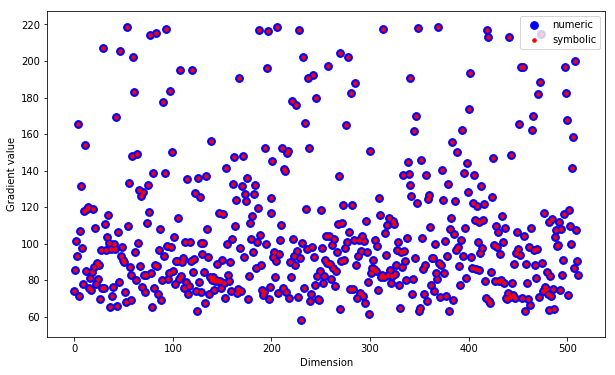

In [8]:
def numericalgradient(fun,w,e):
    # get dimensionality
    d = len(w)
    # initialize numerical derivative
    dh = np.zeros(d)
    # go through dimensions
    for i in range(d):
        # copy the weight vector
        nw = w.copy()
        # perturb dimension i
        nw[i] += e
        # compute loss
        l1, temp = fun(nw)
        # perturb dimension i again
        nw[i] -= 2*e
        # compute loss
        l2, temp = fun(nw)
        # the gradient is the slope of the loss
        dh[i] = (l1 - l2) / (2*e)
    return dh

def checkgrad(fun,w,e):
    # evaluate symbolic gradient from fun()
    loss,dy = fun(w)
    # estimate gradient numerically from fun()
    dh = numericalgradient(fun,w,e)
    
    # ii = dy.argsort()
    ii = np.array([i for i in range(len(dy))])
    
    plt.figure(figsize=(10,6))
    plt.scatter([i for i in range(len(dy))], dh[ii], c='b', marker='o', s=60)
    plt.scatter([i for i in range(len(dy))], dy[ii], c='r', marker='.', s=50)
    plt.xlabel('Dimension')
    plt.ylabel('Gradient value')
    plt.legend(["numeric","symbolic"])
    
    # return the norm of the difference scaled by the norm of the sum
    return np.linalg.norm(dh - dy) / np.linalg.norm(dh + dy)

# set lmbda (λ) arbitrarily
lmbda = 0.1
# dimensionality of the input
_, d = xTr.shape
# evaluate loss on random vector
w = np.random.rand(d)
# the lambda function notation is an inline way to define a function with only a single argument.
ratio = checkgrad(lambda weight: ridge(weight,xTr,yTr,lmbda),w,1e-05)
print("The norm ratio is %.10f." % ratio)

<p>Implement the function <code>adagrad</code> which performs adaptive gradient descent. 
Make sure to include the tolerance variable to stop early if the norm of the gradient is less than the tolerance value (you can use the function <code>np.linalg.norm(x)</code>). When the norm of the gradient is tiny it means that you have arrived at a minimum.  <br>
The first parameter of <code>adagrad</code> is a function which takes a weight vector and returns loss and gradient.
</p>                

In [9]:
#<GRADED>
def adagrad(func,w,alpha,maxiter,eps,delta=1e-02):
    """
    INPUT:
    func    : function to minimize
              (loss, gradient = func(w))
    w       : d dimensional initial weight vector 
    alpha   : initial gradient descent stepsize (scalar)
    maxiter : maximum amount of iterations (scalar)
    eps     : epsilon value
    delta   : if norm(gradient)<delta, it quits (scalar)
    
    OUTPUTS:
     
    w      : d dimensional final weight vector
    losses : vector containing loss at each iteration
    """
    
    losses = np.zeros(maxiter)

    ## fill in your code here
    p = np.zeros(w.shape, dtype = float)
    loss, gradient = func(p)
    count = 0
    
    while np.linalg.norm(gradient) >= delta and count < maxiter:
        loss, gradient = func(w)
        losses[count] = loss
        count += 1
        p += np.power(gradient, 2) + eps*np.ones(w.shape)
        w_newvalue = w - alpha * np.divide(gradient, np.sqrt(p))
        if np.linalg.norm(w_newvalue - w) < eps:
            w = w_newvalue
            break
        w = w_newvalue
    return w, losses
    #raise NotImplementedError('Your code goes here!')
#</GRADED>

Final loss: 0.337442


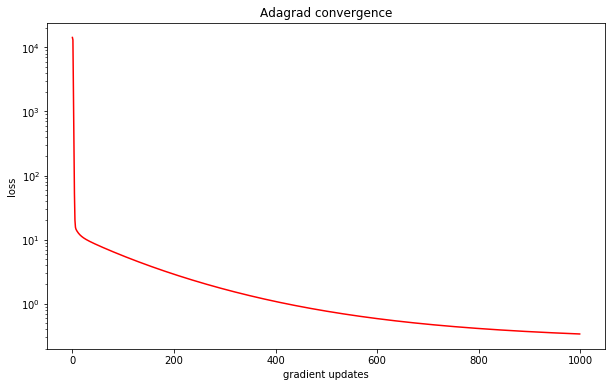

In [10]:
_, d = xTr.shape
eps = 1e-06
w, losses = adagrad(lambda weight: ridge(weight, xTr, yTr, lmbda), np.random.rand(d), 1, 1000, eps)

plt.figure(figsize=(10,6))
plt.semilogy(losses, c='r', linestyle='-')
plt.xlabel("gradient updates")
plt.ylabel("loss")
plt.title("Adagrad convergence")
print("Final loss: %f" % losses[-1])

<p> Write the (almost trivial) function <code>linclassify</code> which returns the predictions for a vector <code>w</code> and a data set <code>xTv</code>. (You can take it from a previous project.)</p>

<p>After this you can check your training and validation accuracy by running the cell below.</p>

In [14]:
print(xTr.shape)
w.shape

(4000, 512)


(512,)

In [15]:
#<GRADED>
def linclassify(w,xTr):
    ## fill in your code here

    preds = np.sign(np.dot(xTr, w))
    return preds
    #raise NotImplementedError('Your code goes here!')
#</GRADED>

# evaluate training accuracy
preds = linclassify(w,xTr)
trainingacc = np.mean(preds==yTr)
# evaluate testing accuracy
preds = linclassify(w,xTv)
validationacc = np.mean(preds==yTv)
print("Training accuracy %2.2f%%\nValidation accuracy %2.2f%%\n" % (trainingacc*100,validationacc*100))

Training accuracy 94.83%
Validation accuracy 83.10%



<p>Now implement the two other loss functions, <code>logistic</code> and <code>hinge</code>. Start off with <code>logistic</code>:</p>

In [10]:
#Method 1 using for loop
def logistic(w,xTr,yTr):
    """
    INPUT:
    w     : d   dimensional weight vector
    xTr   : nxd dimensional matrix (each row is an input vector)
    yTr   : n   dimensional vector (each entry is a label)
    
    OUTPUTS:
    loss     : the total loss obtained with w on xTr and yTr (scalar)
    gradient : d dimensional gradient at w
    """
    n, d = xTr.shape
    
    ## fill in your code here
    loss = 0
    gradient = np.zeros(w.shape)
    for i in range(n):
        e = np.exp(-yTr[i] * np.dot(w.transpose(), xTr[i]))
        loss += np.log(1 + e)
        gradient -= e / (1 + e) * yTr[i] * xTr[i]
    return loss, gradient

    #raise NotImplementedError('Your code goes here!')


In [16]:
#Method 2 workarea
#<GRADED>
def logistic(w,xTr,yTr):
    """
    INPUT:
    w     : d   dimensional weight vector
    xTr   : nxd dimensional matrix (each row is an input vector)
    yTr   : n   dimensional vector (each entry is a label)
    
    OUTPUTS:
    loss     : the total loss obtained with w on xTr and yTr (scalar)
    gradient : d dimensional gradient at w
    """
    n, d = xTr.shape
    
    ## fill in your code here
    loss = 0
    gradient = np.zeros(w.shape)
    wx=innerproduct(w,xTr)
    eneg=np.exp(-1*np.einsum('i,i->i',yTr,wx))
    epos=np.exp(np.einsum('i,i->i',yTr,wx))
    loss=np.einsum('i->',np.log(1+eneg))
    y_num=np.tile(yTr,d).reshape(d,n).transpose()
    denom=np.tile(1+epos,d).reshape(d,n).transpose()
    gradient=np.divide((-1*np.einsum('ij,ij->ij',y_num,xTr)),denom)
    gradient=np.einsum('ij->j',gradient)
    
    
    return loss, gradient
#</GRADED>

In [15]:
#workarea
a=np.tile([1,2,3],4).reshape(4,3).transpose()
b=np.matrix([[1,2],[3,4]])
c=np.matrix([[4,2],[3,7]])
np.divide(b,c)


# dimensionality of the input
xTemp = xTr[:2,:10]
yTemp=yTr[:2]
d=xTemp.shape[1]
# evaluate loss on random vector
w = np.random.rand(d)
# the lambda function notation is an inline way to define a function with only a single argument.
l1,g1=logistic(w,xTemp,yTemp)
print(l1)
print(g1)
print()
l2,g2=logistic(w,xTemp,yTemp)
print(l2)
print(g2)

print()
print(b)
print(c[:,1])
np.dot(b,c[:,1].transpose())

0.3697437402752694
[-0.05696131 -0.05696131  0.         -0.05696131 -0.3243176   0.
 -0.26735629 -0.05696131 -0.3243176  -0.3243176 ]

0.3697437402752694
[-0.05696131 -0.05696131  0.         -0.05696131 -0.3243176   0.
 -0.26735629 -0.05696131 -0.3243176  -0.3243176 ]

[[1 2]
 [3 4]]
[[2]
 [7]]


ValueError: shapes (2,2) and (1,2) not aligned: 2 (dim 1) != 1 (dim 0)

<p>You can use the two cells below to test how well this loss function performs.</p>

The norm ratio is 0.0000000031.


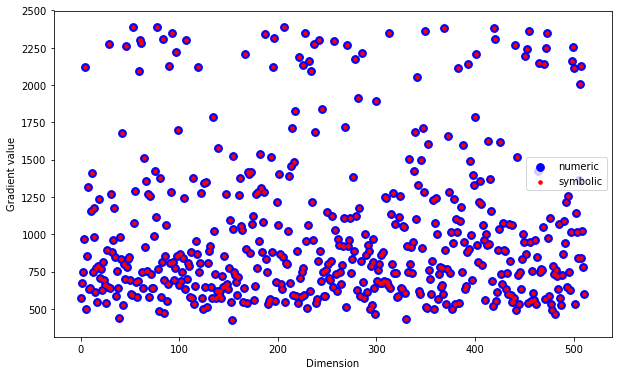

In [17]:
# Gradient sanity check
_, d = xTr.shape
w = np.random.rand(d)
ratio = checkgrad(lambda weight: logistic(weight,xTr,yTr),w,1e-05)
print("The norm ratio is %.10f." % ratio)

In [18]:
w, losses = adagrad(lambda weight: logistic(weight, xTr, yTr), np.random.rand(d), 1, 1000, 1e-06)

# evaluate training accuracy
preds = linclassify(w,xTr)
trainingacc = np.mean(preds==yTr)
# evaluate testing accuracy
preds = linclassify(w,xTv)
validationacc = np.mean(preds==yTv)
print("Training accuracy %2.2f%%\nValidation accuracy %2.2f%%\n" % (trainingacc*100,validationacc*100))

Training accuracy 96.58%
Validation accuracy 88.50%



<p>Now implement <code>hinge</code>:</p>

In [63]:

#Method 1 using for loop
def hinge(w,xTr,yTr,lmbda):
    """
    INPUT:
    w     : d   dimensional weight vector
    xTr   : nxd dimensional matrix (each row is an input vector)
    yTr   : n   dimensional vector (each entry is a label)
    lmbda : regression constant (scalar)
    
    OUTPUTS:
    loss     : the total loss obtained with w on xTr and yTr (scalar)
    gradient : d dimensional gradient at w
    """
    n, d = xTr.shape
    
    ## fill in your code here
    loss = 0
    gradient = 0
    for i in range(n):
        t = 1 - yTr[i]*np.dot(w.transpose(), xTr[i])
        loss += np.max([t, 0])
        if t > 0:
            gradient -= yTr[i]*xTr[i]
    loss += lmbda*np.linalg.norm(w)**2
    gradient += 2*lmbda*w
    return loss, gradient

    #raise NotImplementedError('Your code goes here!')


In [65]:
#Method 2 workarea
#<GRADED>
def hinge(w,xTr,yTr,lmbda):
    """
    INPUT:
    w     : d   dimensional weight vector
    xTr   : nxd dimensional matrix (each row is an input vector)
    yTr   : n   dimensional vector (each entry is a label)
    lmbda : regression constant (scalar)
    
    OUTPUTS:
    loss     : the total loss obtained with w on xTr and yTr (scalar)
    gradient : d dimensional gradient at w
    """
    n, d = xTr.shape
    
    ## fill in your code here
    loss = 0
    gradient = np.zeros(w.shape)
    
    ywx_term=1-np.einsum('i,i->i',yTr,  innerproduct(w,xTr) )
    #element wise max with 0
    z=np.zeros(n)
    ywx_concat=np.concatenate((ywx_term,z)).reshape(-1,n).transpose()
    loss=np.einsum('i->',np.amax(ywx_concat,axis =1)) + (lmbda * np.linalg.norm(w)**2)
    #z=np.zeros(d)
    
    #ywx_concat=np.concatenate(((-1*np.dot(yTr,xTr)),z)).reshape(-1,d).transpose()
    #ywx_term[ywx_term<0]=0
    y_tile=np.tile(yTr,d).reshape(d,-1).transpose()
    yx_term=-1*np.einsum('ij,ij->ij',y_tile,xTr)
    yx_term[np.nonzero(ywx_term<=0),:]=0
    gradient= np.einsum('ij->j',yx_term) + (2*lmbda*w)
    return loss, gradient
#</GRADED>

In [60]:
#workarea
a= np.matrix([-1, 1,-1, -1, 1, 1])
b=np.matrix([[4,3,1,-9,4,-8],[8, -4, 1 ,8,-3 ,7]])
n=b.shape[0]
a1=np.tile(a,n).reshape(n,-1)
c=np.einsum('ij,ij->ij',a1,b)
d=np.matrix([-4, 4])
print(a)
print(b)
print(c)
print(-d)
print(np.nonzero(d<0))
c[np.nonzero(d<0),:]=0
c
#print(np.dot(a,b))
#d=c
#index=np.nonzero(c<0)
#print(index)
#d[index]=0
#print(d)
#indexes=np.nonzero(c<0)
#print(indexes)
#print(a[indexes])
#c[c>0]=np.dot(a[indexes],b[:,indexes])

[[-1  1 -1 -1  1  1]]
[[ 4  3  1 -9  4 -8]
 [ 8 -4  1  8 -3  7]]
[[-4  3 -1  9  4 -8]
 [-8 -4 -1 -8 -3  7]]
[[ 4 -4]]
(array([0]), array([0]))


array([[ 0,  0,  0,  0,  0,  0],
       [-8, -4, -1, -8, -3,  7]])

In [66]:
a=np.ndarray([2,2])
a=np.matrix([[1,-2],[-9,4]])
#print(a.shape)
b=np.zeros((3))
#print(b.shape)
#c = np.concatenate((a,b), axis=1)
#print(np.max(c,axis =1))
#c
a=np.array([1,2,3])
np.concatenate((a,b)).reshape(-1,3).transpose()

xTemp = xTr[:2,:10]
yTemp=yTr[:2]
d=xTemp.shape[1]
# evaluate loss on random vector
w = np.random.rand(xTr.shape[1])

l1,g1=hinge(w,xTr,yTr,1e-05)
#print(l1)
#print(g1)
print()
l2,g2=hinge1(w,xTr,yTr,1e-05)
#print(l2)
#print(g2)
print(l1,l2)
print(g1[:10])
(g2[:10])


262231.7801090322 262231.7801090319
[ 573.00000463  674.00001713  750.0000173   968.00000033 2124.00000744
  499.00001605  852.00001052 1318.00000813  632.00001493  640.00000412]


array([ 573.00000463,  674.00001713,  750.0000173 ,  968.00000033,
       2124.00000744,  499.00001605,  852.00001052, 1318.00000813,
        632.00001493,  640.00000412])

<p>You can use the two cells below to test how well this loss function performs.</p>

The norm ratio is 0.0000000048.


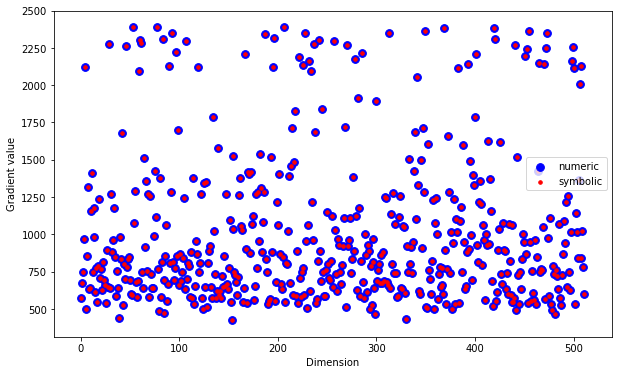

In [67]:
# Gradient sanity check
lmbda = 0.1
_, d = xTr.shape
w = np.random.rand(d)
ratio = checkgrad(lambda weight: hinge(weight,xTr,yTr,lmbda),w,1e-05)
print("The norm ratio is %.10f." % ratio)

In [68]:
w, losses = adagrad(lambda weight: hinge(weight, xTr, yTr, lmbda), np.random.rand(d), 1, 1000, 1e-06)

# evaluate training accuracy
preds = linclassify(w,xTr)
trainingacc = np.mean(preds==yTr)
# evaluate testing accuracy
preds = linclassify(w,xTv)
validationacc = np.mean(preds==yTv)
print("Training accuracy %2.2f%%\nValidation accuracy %2.2f%%\n" % (trainingacc*100,validationacc*100))

Training accuracy 98.30%
Validation accuracy 88.10%



<h3>Competition <b>(Optional)</b></h3>

<p>The competition for this assignment is split into two components:</p>

<ol>
<li><b>Feature Extraction</b>:
Modify the function <code>extractfeaturescomp</code>.
This function takes in a file path <code>path</code> and
a feature dimension <code>B</code> and should output a feature vector of dimension <code>B</code>.
The autograder will pass in a file path pointing to a file that contains an email,
and set <code>B</code> = <code>feature_dimension</code>.
We provide <code>extractfeaturesnaive</code> as an example.
</li>
<li><b>Model Training</b>:
Modify the function <code>trainspamfiltercomp</code>.
This function takes in training data <code>xTr</code> and training labels <code>yTr</code> and
should output a weight vector <code>w</code> for linear classification.
We provide an initial implementation using Adagrad and ridge regression.
</li>
</ol>

<p>Your model will be trained on the same training set above (loaded by <code>loadspamdata</code>), but we will test its accuracy on a secret dataset of emails.</p>

In [69]:
#<GRADED>
feature_dimension = 2048
def extractfeaturescomp(path, B):
    '''
    INPUT:
    path : file path of email
    B    : dimensionality of feature vector
    
    OUTPUTS:
    x    : B dimensional vector
    '''
    x = np.zeros(B)
    with open(path, 'r') as femail:
        email = femail.read()
        # breaks for non-ascii characters
        tokens = email.split()
        for token in tokens:
            x[hash(token) % B] = 1
    return x
#</GRADED>

In [70]:
#<GRADED>
def trainspamfiltercomp(xTr, yTr):
    '''
    INPUT:
    xTr : nxd dimensional matrix (each row is an input vector)
    yTr : d   dimensional vector (each entry is a label)
    
    OUTPUTS:
    w : d dimensional vector for linear classification
    '''

    n, d = xTr.shape
    acc_best = 0
    lmbda = 0.1
    w = np.random.rand(np.shape(xTr)[1])
    eps = 1e-06
    w, losses = adagrad(lambda w: hinge(w, xTr, yTr, lmbda), np.random.rand(d), 0.3, 1000, eps)
    return w
    
    #w = np.random.rand(np.shape(xTr)[1])
    #return w
#</GRADED>